### Prepare the dataset

In [1]:
import numpy as np
import shutil
from sklearn.neighbors import KernelDensity
from scipy import signal
import pandas as pd
import re, time
import matplotlib.pyplot as plt
import sys,os,scipy,torch,warnings, copy
import mat73,math, copy
import neurokit2 as nk
from scipy.signal import find_peaks
%matplotlib inline

In [2]:
def down_sample(ecg, target_len=200):
    # using numpy
    ecg=np.interp(np.linspace(0, len(ecg), target_len), np.arange(len(ecg)), ecg)
    return ecg
# normlizaiton to [0,1]
def sst_norm_01(sst):
    for i in range(len(sst)):
        k=1/(np.max(sst[i])-np.min(sst[i]))
        sst[i] = 0+k*(sst[i]-np.min(sst[i]))
    return sst
def load_sst(sst_path):
    """
    load sst result generated from matlab
    """
    sst_plot = mat73.loadmat(sst_path, use_attrdict=True)
    # sst_plot = scipy.io.loadmat(sst_path, use_attrdict=True)
    sst_plot = np.flip(sst_plot['SST'], 1)
    return sst_plot
# normalize ECG to [0,1]
def normal_ecg(ECG):
    ECG = (ECG - np.min(ECG)) / (np.max(ECG) - np.min(ECG))
    return ECG
def normal_rcg(RCG):
    for i in range(len(RCG)):
        k=2/(np.max(RCG[i])-np.min(RCG[i]))
        RCG[i] = -1+k*(RCG[i]-np.min(RCG[i]))
    return RCG
def index_convert(index, freq_org=200, freq_desired=30):
    return int(index * freq_desired / freq_org)

In [3]:
def des_path_finder(index,path):
    for file in os.listdir(path):
        if re.search(f'_{index}_', file):
            return file
def resample(data, org_freq, new_freq):
    return nk.signal_resample(data, sampling_rate=org_freq, desired_sampling_rate=new_freq)
def smooth2nd(x,M): ##x 为一维数组
    K = round(M/2-0.1) ##M应为奇数，如果是偶数，则取大1的奇数
    lenX = len(x)
    if lenX<2*K+1:
        print('数据长度小于平滑点数')
    else:
        y = np.zeros(lenX)
        for NN in range(0,lenX,1):
            startInd = max([0,NN-K])
            endInd = min(NN+K+1,lenX)
            y[NN] = np.mean(x[startInd:endInd])
##    y[0]=x[0]       #首部保持一致
##    y[-1]=x[-1]     #尾部也保持一致
    return(y)
def copy_allfiles(src,dest):
#src:原文件夹；dest:目标文件夹
  src_files = os.listdir(src)
  for file_name in src_files:
    full_file_name = os.path.join(src, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, dest)
def peak_error(gts, pred):
    out = []
    for peak in gts:
        errors = peak - pred
        err_abs = np.abs(errors)
        idx = np.where(err_abs == np.min(err_abs))[0]
        out.append(errors[idx[0]])
    return np.array(out)

### For QAQ dataset

In [13]:
# generate dataset
seg_length = 800
freq =200
tt, aa = [], []
trial_count = 0
low_snr_count = 0
for i in range(1,11):
    path_des=f"/home/zhangyuanyuan/Dataset/QAQ_Dataset/obj_{i}_/"
    folders = os.listdir(path_des)
    for folder in folders:
        if folder == '.DS_Store':
            continue
        with open(os.path.join(path_des, folder, 'recommend.txt'), 'r') as f:
            recommend = eval(f.read())
        offset = (recommend['offset'])  
        print(folder, offset, trial_count)
        ECG_path, PPI_path, Anchor_path = os.path.join(path_des, folder, 'ECG_data'), os.path.join(path_des, folder, 'PPI_data'), os.path.join(path_des, folder, 'Anchor_data')
        if not os.path.exists(ECG_path):
            os.mkdir(ECG_path)
        if not os.path.exists(PPI_path):
            os.mkdir(PPI_path)
        if not os.path.exists(Anchor_path):
            os.mkdir(Anchor_path)
            
        files = os.listdir(os.path.join(path_des, folder))
        ECG_file = [file for file in files if re.search('ecg_data', file)]
        npzfile = np.load(os.path.join(path_des, folder, ECG_file[0]))
        ECG_total = npzfile['ecg']
        timestamp = npzfile['timestamp']
        start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(timestamp[0]))
        end_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(timestamp[-1]))
        duration = timestamp[-1] - timestamp[0]
        if np.round(len(ECG_total) / duration) != freq:
            print(f'ECG frequency is not {freq}Hz')
            break

        seg_files = os.listdir(os.path.join(path_des, folder, 'SST_data'))
        error_for_obj = np.array([])
        for_check_ecg = []
        for_check_energy = []
        
        for seg in seg_files:
            if seg == '.DS_Store':
                continue

            start = int(re.search('start_(.*)\.0_.npy', seg).group(1))*freq 
            sst = np.load(os.path.join(path_des, folder, 'SST_data', seg))
            sst_mean = sst[0]
            sst_energy = resample(normal_ecg(np.sum(sst_mean, axis=0)), 30, 200)
            peaks_sst = find_peaks(sst_energy, distance=100, height=0.2)[0]

            if len(peaks_sst)<=2:
                print(f'Poor SNR in {seg}')
                os.remove(os.path.join(path_des, folder, 'SST_data', seg))
                low_snr_count += 1
                continue
            
            start += offset
            ecg_temp = normal_ecg(ECG_total[start:start+seg_length])
            ecg_temp = smooth2nd(ecg_temp, 5)
            ecg_temp = normal_ecg(ecg_temp)
            if len(ecg_temp)  != 800:
                # padd the signal to 800 with the last value
                ecg_temp = np.pad(ecg_temp, (0, 800-len(ecg_temp)), 'edge')
                tt.append(ecg_temp)
            for_check_ecg.append(ecg_temp)
            for_check_energy.append(sst_energy)
            peaks_ecg = find_peaks((ecg_temp), distance=100, height=0.2, prominence=0.5, wlen=50)[0]

            anchor = np.zeros_like(ecg_temp)
            anchor[peaks_ecg] = 1
            aa.append(anchor)
            ppi_data = np.zeros(260)
            ppi_data[int(np.mean(np.diff(peaks_ecg)))] = 1
            if len(ecg_temp)  != 800:
                print(f'Error in {seg}')

            # remove data_sst_ from seg
            id_save = re.search('data_sst_(.*)', seg).group(1)
            # np.save(os.path.join(ECG_path, f'data_ecg_{id_save}'), ecg_temp)
            # np.save(os.path.join(Anchor_path, f'data_anchor_{id_save}'), anchor)
            # np.save(os.path.join(PPI_path, f'data_ppi_{id_save}'), ppi_data)
            trial_count += 1
        break
    break

data_2025-02-17_15_54_17_05 -29 0


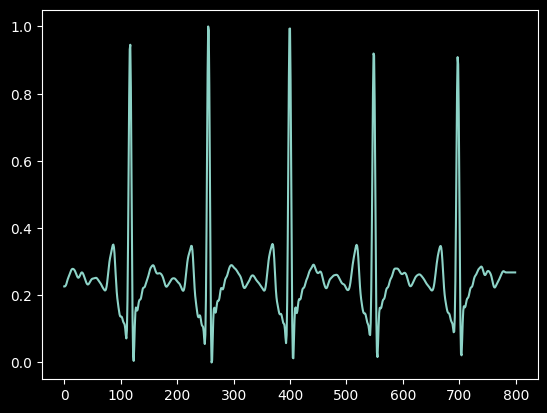

In [ ]:
plt.plot(tt[5])

115


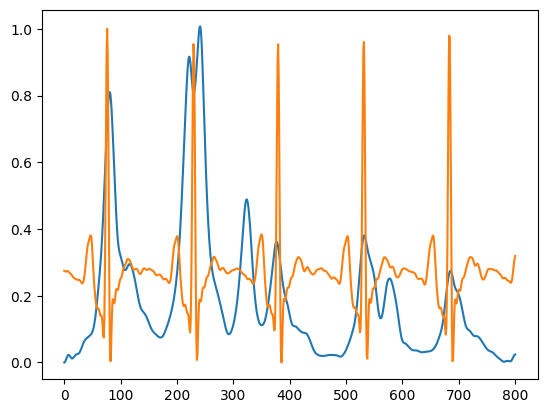

In [ ]:
select = 17
print(len(for_check_ecg))
ecg_temp = for_check_ecg[select]
sst_energy = for_check_energy[select]
t = np.linspace(0, 800, 800)
plt.plot(t, sst_energy)
plt.plot(t, ecg_temp)

In [18]:
# prepare QAQ_dataset_for_traning
path_des="/home/zhangyuanyuan/Dataset/QAQ_Dataset/"
save_path = "/home/zhangyuanyuan/Dataset/data_RFcardi/"
seg_length = 800
folders = os.listdir(path_des)
trial_strc = []
trial_count = 1
for obj in range(1,11):
    path_temp = f'{path_des}obj_{obj}_/'
    folders = os.listdir(path_temp)

    for index, folder in enumerate(folders):
        if folder == '.DS_Store':
            continue
        new_folder_name = f'{save_path}/obj{obj}_{trial_count}_/'
        print(folder,trial_count)
        trial_strc.append([folder, trial_count])
        if not os.path.exists(new_folder_name):
            os.mkdir(new_folder_name)
        files = os.listdir(os.path.join(path_temp, folder))
        ECG_path, PPI_path, Anchor_path, SST_path = os.path.join(path_temp, folder, 'ECG_data/'), os.path.join(path_temp, folder, 'PPI_data/'), os.path.join(path_temp, folder, 'Anchor_data/'), os.path.join(path_temp, folder, 'SST_data/')
        # copy all the files from ECG_path, PPI_path, Anchor_path to new_folder_name
        # for file in os.listdir(ECG_path):
        #     if file == '.DS_Store':
        #         continue
        #     os.system(f'cp {os.path.join(ECG_path, file)} {os.path.join(new_folder_name, file)}')
        # for file in os.listdir(PPI_path):
        #     if file == '.DS_Store':
        #         continue
        #     os.system(f'cp {os.path.join(PPI_path, file)} {os.path.join(new_folder_name, file)}')
        # for file in os.listdir(Anchor_path):
        #     if file == '.DS_Store':
        #         continue
        #     os.system(f'cp {os.path.join(Anchor_path, file)} {os.path.join(new_folder_name, file)}')
        # for file in os.listdir(SST_path):
        #     if file == '.DS_Store':
        #         continue
        #     os.system(f'cp {os.path.join(SST_path, file)} {os.path.join(new_folder_name, file)}')
        # print(new_folder_name)
        trial_count += 1
        # if trial_count == 79:
        #     print(path_temp, folder)
    #     break
    # break
# save the trial structure
np.save(os.path.join('trial_structure.npy'), trial_strc)
    

data_2025-02-17_15_54_17_05 1
data_2025-02-17_15_55_58_05 2
data_2025-02-17_15_49_36_05 3
data_2025-02-17_15_47_35_05 4
data_2025-02-24_13_59_25_10 5
data_2025-02-17_15_46_16_05 6
data_2025-02-24_13_56_13_10 7
data_2025-02-17_15_44_29_05 8
data_2025-02-17_15_52_49_05 9
data_2025-02-17_14_25_36_05 10
data_2025-02-17_14_36_58_05 11
data_2025-02-17_14_39_32_05 12
data_2025-02-17_14_18_01_05 13
data_2025-02-17_14_29_44_05 14
data_2025-02-17_14_33_47_05 15
data_2025-02-17_14_23_41_05 16
data_2025-02-17_14_31_06_05 17
data_2025-02-17_14_28_28_05 18
data_2025-02-24_14_58_50_05 19
data_2025-02-24_15_02_39_05 20
data_2025-02-24_15_18_30_05 21
data_2025-02-24_14_48_16_10 22
data_2025-02-24_14_45_01_10 23
data_2025-02-24_14_55_43_05 24
data_2025-02-24_15_05_51_05 25
data_2025-02-17_16_13_14_05 26
data_2025-02-17_15_36_55_05 27
data_2025-02-17_15_02_34_05 28
data_2025-02-17_14_40_56_05 29
data_2025-02-17_14_42_19_05 30
data_2025-02-17_14_58_14_05 31
data_2025-02-17_14_45_33_05 32
data_2025-02-17_1

In [16]:
files

['ECG_data',
 'Anchor_data',
 'adc_data_17_15_54_15_Raw_LogFile.csv',
 'MA_BF_results',
 'SST_data',
 'PPI_data',
 'History',
 'ecg_data_2025-02-17_15_54_17_05.npz',
 'recommend.txt']

In [ ]:
# calibration
path_des = "/home/zhangyuanyuan/Dataset/data_QAQ/"
seg_length = 800
folders = os.listdir(path_des)
trial_count = 0
low_snr_count = 0
poor_plot = []
for obj in range(1,11):
    folders = os.listdir(path_des)
    # print(folders)
    for index, folder in enumerate(folders):
        if folder == '.DS_Store':
            continue
        # if index != 2:
        #     continue
        print(folder)
        ECG_prefix, PPI_prefix, Anchor_prefix, SST_prefix = 'data_ecg_', 'data_ppi_', 'data_anchor_', 'data_sst_'
        # count the number of files with these prefix
        ECG_files = [file for file in os.listdir(os.path.join(path_des, folder)) if re.search(ECG_prefix, file)]
        PPI_files = [file for file in os.listdir(os.path.join(path_des, folder)) if re.search(PPI_prefix, file)]
        Anchor_files = [file for file in os.listdir(os.path.join(path_des, folder)) if re.search(Anchor_prefix, file)]
        SST_files = [file for file in os.listdir(os.path.join(path_des, folder)) if re.search(SST_prefix, file)]
        # check if the number of files are the same
        if len(ECG_files) != len(PPI_files) or len(ECG_files) != len(Anchor_files) or len(ECG_files) != len(SST_files):
           print(len(ECG_files), len(PPI_files), len(Anchor_files), len(SST_files))
           print(f'Error: {folder} has different number of files')   
        # sort the files based on the first number in the file name
        # ECG_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))
        # PPI_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))
        Anchor_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))
        SST_files.sort(key=lambda x: int(re.search(r'\d+', x).group()))
        err = np.array([])
        for i in range(len(Anchor_files)):
            # i = 28
            # print(Anchor_files[i], SST_files[i])
            anchor = np.load(os.path.join(path_des, folder, Anchor_files[i]))
            sst_ = np.load(os.path.join(path_des, folder, SST_files[i]))
            sst_ = copy.deepcopy(sst_)
            sst_mean = np.mean(sst, axis=0)
            sst_mean = sst[0]
            sst_energy = resample(normal_ecg(np.sum(sst_mean, axis=0)), 30, 200)
            peaks_sst = find_peaks(sst_energy, distance=100, height=0.2)[0]
            if len(peaks_sst)<=2:
                print(f'Poor SNR in {SST_files[i]}')
                low_snr_count += 1
                poor_plot.append(sst_energy)
                continue
            peaks_anchor = np.where(anchor == 1)[0]
            err = np.concatenate((err, peak_error(peaks_anchor, peaks_sst)))
            trial_count += 1
        # break
    # break
    

obj10_81_
obj7_55_
obj5_45_
obj6_48_
obj7_62_
obj2_12_
obj7_59_
obj6_51_
obj5_40_
obj2_10_
obj10_77_
obj10_78_
obj2_14_
obj3_24_
obj3_20_
obj9_75_
obj7_61_
obj4_33_
obj9_72_
obj2_13_
obj8_64_
obj6_50_
obj10_79_
obj4_30_
obj3_27_
obj2_11_
obj2_18_
obj8_68_
obj7_56_
obj7_58_
obj8_67_
obj3_21_
obj2_16_
obj7_57_
obj4_34_
obj4_35_
obj9_71_
obj3_26_
obj6_53_
obj1_5_
obj1_1_
obj3_25_
obj1_9_
obj4_31_
obj3_22_
obj9_73_
obj2_17_
obj3_19_
obj7_54_
obj6_52_
obj10_80_
obj1_6_
obj5_37_
obj6_49_
obj6_46_
obj1_8_
obj8_69_
obj5_42_
obj1_4_
obj4_32_
obj8_65_
obj6_47_
obj5_39_
obj4_29_
obj5_41_
obj4_36_
obj5_38_
obj1_2_
obj8_66_
obj2_15_
obj1_3_
obj10_76_
obj1_7_
obj7_60_
obj8_70_
obj4_28_
obj8_63_
obj5_43_
obj5_44_
obj9_74_
obj3_23_
obj10_81_
obj7_55_
obj5_45_
obj6_48_
obj7_62_
obj2_12_
obj7_59_
obj6_51_
obj5_40_
obj2_10_
obj10_77_
obj10_78_
obj2_14_
obj3_24_
obj3_20_
obj9_75_
obj7_61_
obj4_33_
obj9_72_
obj2_13_
obj8_64_
obj6_50_
obj10_79_
obj4_30_
obj3_27_
obj2_11_
obj2_18_
obj8_68_
obj7_56_
obj7_58_


In [ ]:
low_snr_count, trial_count

(0, 58310)

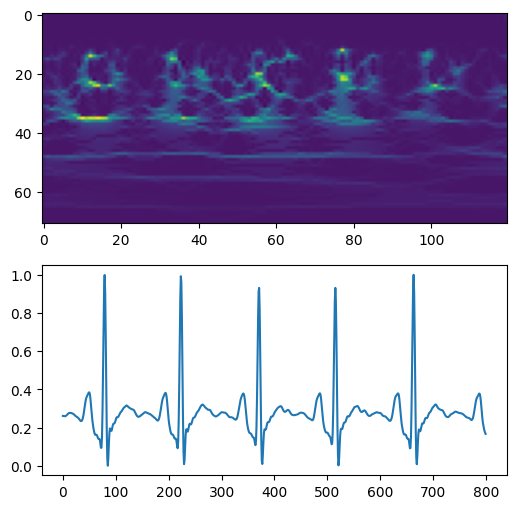

In [ ]:
# check the alignment of sst and anchor mask
subj = 'obj1_4_'
path_des = "/home/zhangyuanyuan/Dataset/data_QAQ/"
files = os.listdir(path_des+f"/{subj}")
temp_id = 5
files = [file for file in files if re.search(f'_{temp_id}_start', file)]
sst_file = [file for file in files if re.search('sst', file)]
ECG_file = [file for file in files if re.search('ecg', file)]
sst_org = sst_norm_01(np.load(path_des+f"/{subj}/"+sst_file[0]))
# anchor_seg=np.load(path_des+f"/{subj}/anchor_seg_{temp_id}.npy")
ecg_seg = np.load(path_des+f"/{subj}/"+ECG_file[0])
plt.figure(figsize=(6, 6)) 
sst_org = sst_org[0,:,:]
plt.subplot(211)
plt.imshow(sst_org, aspect='auto')
plt.subplot(212)
# plt.plot(((anchor_seg)))
plt.plot(ecg_seg)
# temp = df['ECG'][79][temp_id*160:temp_id*160+800]
# plt.plot(temp)
# print(len(ecg_seg))
plt.style.use('default')
# plt.legend(['anchor', 'ECG', 'ground truth'])

### Generation

In [ ]:
obj_index = 1
DTM_info = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/DTM_info/{obj_index}_seg.npy', allow_pickle=True).item()
DTM_info['point'][0]

array([36, 31, 21, 48, 45, 39, 28, 32, 35, 16])

In [ ]:
# segment based on steps
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/" # segment with arbitrary ECG gts
start_index = 0
step =160
seg_length = 800
f_org, f_sst = 200, 30
len_max, len_min = 0,1000
freq_anchor = 200 # the output length for 4 sec anchor mask is 800
freq_sst = 30 # the input length for 4 sec sst is 120

for obj_index in range(1,92):
    print(obj_index)
    seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
    R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))   
    R_peaks_convert = np.array([index_convert(i,200,freq_anchor) for i in R_peaks]) 
    start_array, end_array = seg_df['start'].values, seg_df['end'].values
    sst_path =os.path.join(sst_org_root,sst_path_finder(obj_index,sst_org_root))
    sst_temp = load_sst(sst_path)
    DTM_info = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/DTM_info/{obj_index}_seg.npy', allow_pickle=True).item()
    file_id = 0
    save_path=os.path.join(path_des, des_path_finder(obj_index,path_des))
    print(save_path)
    anchor_mask_total = np.zeros(index_convert(35505, 200, freq_anchor))
    for item in R_peaks_convert:
        anchor_mask_total[item] = 1
    for i in range(0, (35505-seg_length)//step):
        start_index = i*step
        end_index = start_index + seg_length
        bp = DTM_info['point'][i]

        # # seg for sst
        sst_seg_start = index_convert(start_index, 200, freq_sst)
        sst_seg = copy.deepcopy(sst_temp[bp, :, sst_seg_start:sst_seg_start+120])
        sst_seg = sst_norm_01(sst_seg)
        # seg for anchor
        anchor_mask = anchor_mask_total[index_convert(start_index, 200, freq_anchor):index_convert(start_index, 200, freq_anchor)+seg_length*freq_anchor//200]
        
        R_peak_index = np.where((R_peaks > start_index) & (R_peaks < end_index))[0]
        R_peak_index = R_peaks[R_peak_index]
        selected_R_peak = np.argmin(np.abs(R_peak_index - (end_index-start_index)//2))
        R_peak_index = R_peak_index[selected_R_peak]
        # seg for ECG
        ecg_index = np.where((start_array <= R_peak_index))[0][-1]
        temp_start, temp_end = start_array[ecg_index], start_array[ecg_index+1] # the end is the start of next ecg seg
        ecg_seg = df['ECG'][obj_index-1][start_index:end_index]
        
        # fake mask, which is actually the raw ECG signal
        anchor_mask_ = down_sample(df['ECG'][obj_index-1][start_index:end_index], 200)

        if len(ecg_seg) < len_min:
            len_min = len(ecg_seg)
        if len(ecg_seg) > len_max:
            len_max = len(ecg_seg)
        np.save(os.path.join(save_path, f'anchor_seg_{file_id}.npy'), anchor_mask)
        np.save(os.path.join(save_path, f'ecg_seg_{file_id}.npy'), ecg_seg)
        np.save(os.path.join(save_path, f'sst_seg_{file_id}.npy'), sst_seg)
        file_id += 1


1
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj1_NB_1_
2
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj1_NB_2_
3
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj2_NB_3_
4
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj2_NB_4_
5
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_IB_5_
6
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_IB_6_
7
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_NB_7_
8
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_NB_8_
9
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_NB_9_
10
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_NB_10_
11
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_NB_11_
12
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_NB_12_
13
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_SP_13_
14
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/obj5_PE_14_
15
/home/z

In [ ]:
# segment based on steps
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/" # segment according to the step
start_index = 0
step =160
seg_length = 800
f_org, f_sst = 200, 30
len_max, len_min = 0,1000
freq_anchor = 200 # the output length for 4 sec anchor mask is 800
freq_sst = 30 # the input length for 4 sec sst is 120

for obj_index in range(1,92):
    print(obj_index)
    seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
    R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))   
    R_peaks_convert = np.array([index_convert(i,200,freq_anchor) for i in R_peaks]) 
    start_array, end_array = seg_df['start'].values, seg_df['end'].values
    sst_path =os.path.join(sst_org_root,sst_path_finder(obj_index,sst_org_root))
    sst_temp = load_sst(sst_path)
    DTM_info = np.load(f'/home/zhangyuanyuan/Dataset/data_MMECG/DTM_info/{obj_index}_seg.npy', allow_pickle=True).item()
    file_id = 0
    save_path=os.path.join(path_des, des_path_finder(obj_index,path_des))
    print(save_path)
    anchor_mask_total = np.zeros(index_convert(35505, 200, freq_anchor))
    for item in R_peaks_convert:
        anchor_mask_total[item] = 1
    for i in range(0, (35505-seg_length)//step):
        start_index = i*step
        end_index = start_index + seg_length
        bp = DTM_info['point'][i]

        # # seg for sst
        sst_seg_start = index_convert(start_index, 200, freq_sst)
        sst_seg = copy.deepcopy(sst_temp[bp, :, sst_seg_start:sst_seg_start+120])
        sst_seg = sst_norm_01(sst_seg)
        # seg for anchor
        anchor_mask = anchor_mask_total[index_convert(start_index, 200, freq_anchor):index_convert(start_index, 200, freq_anchor)+800*freq_anchor//200]
        
        R_peak_index = np.where((R_peaks > start_index) & (R_peaks < end_index))[0]
        R_peak_index = R_peaks[R_peak_index]
        selected_R_peak = np.argmin(np.abs(R_peak_index - (end_index-start_index)//2))
        R_peak_index = R_peak_index[selected_R_peak]
        # seg for ECG
        ecg_index = np.where((start_array <= R_peak_index))[0][-1]
        temp_start, temp_end = start_array[ecg_index], start_array[ecg_index+1] # the end is the start of next ecg seg
        ecg_seg = df['ECG'][obj_index-1][temp_start:temp_end]
        
        # fake mask, which is actually the raw ECG signal
        anchor_mask_ = down_sample(df['ECG'][obj_index-1][start_index:end_index], 200)

        if len(ecg_seg) < len_min:
            len_min = len(ecg_seg)
        if len(ecg_seg) > len_max:
            len_max = len(ecg_seg)
        np.save(os.path.join(save_path, f'anchor_seg_{file_id}.npy'), anchor_mask)
        np.save(os.path.join(save_path, f'ecg_seg_{file_id}.npy'), ecg_seg)
        np.save(os.path.join(save_path, f'sst_seg_{file_id}.npy'), sst_seg)
        file_id += 1


1
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj1_NB_1_
2
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj1_NB_2_
3
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj2_NB_3_
4
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj2_NB_4_
5
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_IB_5_
6
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_IB_6_
7
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_NB_7_
8
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_NB_8_
9
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_NB_9_
10
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_NB_10_
11
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_NB_11_
12
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_NB_12_
13
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_light/obj5_SP_13_
14
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step_

In [ ]:
# segment based single cycle ECG, this cell put the R peak in the middle of the segment
path_des="/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/" # segment according to single cycle ECG
start_index = 0
step =160
seg_length = 800
f_org, f_sst = 200, 30
len_max, len_min = 0,1000
freq_anchor = 200 # the output length for 4 sec anchor mask is 200
freq_sst = 30 # the input length for 4 sec sst is 120
for obj_index in range(1,92):
    print(obj_index)
    seg_df = pd.read_csv(os.path.join(ecg_seg_index_root,f'ecg_seg_index_{obj_index}.csv'), index_col=None)
    R_peaks = np.load(os.path.join(peak_root, f'{obj_index}_R_peak_gts.npy'))   
    R_peaks_convert = np.array([index_convert(i,200,freq_anchor) for i in R_peaks]) 
    start_array, end_array = seg_df['start'].values, seg_df['end'].values
    sst_path =os.path.join(sst_org_root,sst_path_finder(obj_index,sst_org_root))
    sst_temp = load_sst(sst_path)
    file_id = 0
    save_path=os.path.join(path_des, des_path_finder(obj_index,path_des))
    print(save_path)
    anchor_mask_total = np.zeros(index_convert(35505, 200, freq_anchor))
    for item in R_peaks_convert:
        anchor_mask_total[item] = 1
    for i in range(0, len(seg_df)-1):
        ecg_start_index = start_array[i]
        ecg_end_index = start_array[i+1]
        R_selected_index = np.where((R_peaks > ecg_start_index) & (R_peaks < ecg_end_index))[0][0]
        ecg_length = ecg_end_index-ecg_start_index
        append_length = 800-ecg_length

        # sometimes the start index is negative
        if ecg_start_index<=0:
            ecg_start_index = 0
        start_index = R_peaks[R_selected_index]-400
        start_index = 1 if start_index <= 0 else start_index
        if start_index+800 > 35505:
            continue
        # convert for DTM info
        dtm_index = start_index//step
        if dtm_index >= len(DTM_info['point']):
            # print(i, 'out of range', ecg_start_index)
            continue
        bp = DTM_info['point'][dtm_index]
        # seg for sst
        sst_seg_start = index_convert(start_index, 200, freq_sst)
        sst_seg_start = 1 if sst_seg_start <= 0 else sst_seg_start
        sst_seg = copy.deepcopy(sst_temp[bp, :, sst_seg_start:sst_seg_start+120])
        sst_seg = sst_norm_01(sst_seg)
        # seg for anchor
        anchor_seg_start = index_convert(start_index, 200, freq_anchor)
        anchor_mask = anchor_mask_total[anchor_seg_start:anchor_seg_start+800*freq_anchor//200]
        
        # seg for ECG
        ecg_seg = df['ECG'][obj_index-1][ecg_start_index:ecg_end_index]

        # # fake mask, which is actually the raw ECG signal
        anchor_mask_ = down_sample(df['ECG'][obj_index-1][start_index:start_index+800], 200)

        if len(ecg_seg) < len_min:
            len_min = len(ecg_seg)
        if len(ecg_seg) > len_max:
            len_max = len(ecg_seg)
        if len(ecg_seg) < 5:
            print(obj_index, i, len(ecg_seg), start_array[0], ecg_end_index)
            print('too short')
            continue
        np.save(os.path.join(save_path, f'anchor_seg_{file_id}.npy'), anchor_mask)
        np.save(os.path.join(save_path, f'ecg_seg_{file_id}.npy'), ecg_seg)
        np.save(os.path.join(save_path, f'sst_seg_{file_id}.npy'), sst_seg)
        file_id += 1
    print(file_id)


1
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj1_NB_1_
198
2
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj1_NB_2_
187
3
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj2_NB_3_
235
4
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj2_NB_4_
234
5
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj5_IB_5_
230
6
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj5_IB_6_
211
7
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj5_NB_7_
243
8
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj5_NB_8_
230
9
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj5_NB_9_
233
10
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj5_NB_10_
243
11
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj5_NB_11_
227
12
/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_sce_middle_light/obj5_NB_12_
241
13
/home/z

In [ ]:
len(DTM_info['point'])

216

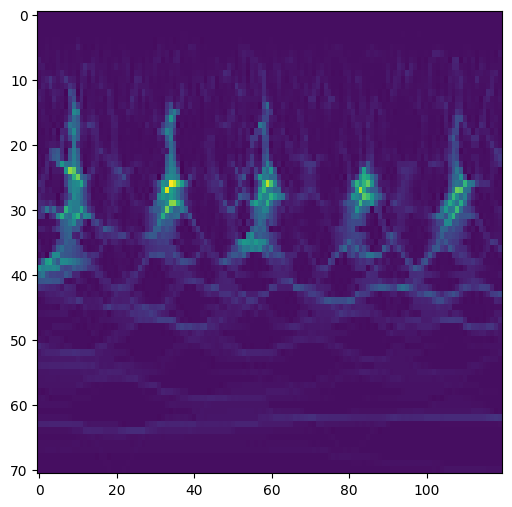

In [ ]:
# check the alignment of sst and anchor mask
subj = 'obj30_IB_80_'
subj = 'obj1_NB_1_'
path_des = "/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_transfer/"
# path_des = '/home/zhangyuanyuan/Dataset/data_MMECG/data_seg_step/'
temp_id = 20
sst_org = sst_norm_01(np.load(path_des+f"/{subj}/sst_seg_{temp_id}.npy"))
anchor_seg=np.load(path_des+f"/{subj}/anchor_seg_{temp_id}.npy")
ecg_seg = np.load(path_des+f"/{subj}/ecg_seg_{temp_id}.npy")
plt.figure(figsize=(6, 6)) 
sst_org = sst_org[0,:,:]
# plt.subplot(211)
plt.imshow(sst_org, aspect='auto')
# plt.subplot(212)
# plt.plot(((anchor_seg)))
# plt.plot(ecg_seg)
# temp = df['ECG'][79][temp_id*160:temp_id*160+800]
# plt.plot(temp)
# print(len(ecg_seg))
# plt.style.use('default')
# plt.legend(['anchor', 'ECG', 'ground truth'])